<center>
<h1>Use NLP to Score Candidate</h1>

## Workflow

### 1. Pick a method:

To sore the candidate using NLP, the common way is to create a keyword list and use the context of resume to match them.

There are two popular way to create the keyword list:
- Use the related corpus (here, it is the corpus of data science); create keyword list using model of `Word2Vec`; use `model.wv.most_similar` function to find the desired keyword list of each field. eg. use 
`model.wv.most_similar ("scripting languages")` to find the keyword list of scripting languages; use that list to match resume.


- Create the key list using the given dataset. Here, go through the 74 resumes and extract keyword list for each field and use that to match resume.

The 1st method saves a lot of time searching the keyword in dataset. But it has 2 main disadvantages:
- `Require large and accurate dataset` -When the appropriate dataset can’t be found, the corresponding keyword list would be less relevant.
- `Require much time to train the model` -When the dataset is large, it would take a lot of time to process it.

After getting an irrelevant keyword list using method 1, I chose to create list by myself.

### 2. Create the keyword list:

I combined the 6 requirements in the "Qualifications" in to three categories and pointed out the area where you can find these key requirements in the dic:


**Education**



- A: `Major` - "education"


**Working Experience**


- B: `5-10 years of experience in data science` - most in "strength"

- C: `Experience working with international partners` - "strength" & "job description"



**Hard skills**


- D: `Date science model`  - "strength" & "job description"

- E: `Large data set & analytical tool`  - "strength" & "job description"

- F: `Scripting languages`  - "strength" & "job description"

I **separate** the dataset to 3 parts: `"education"`, `"strength"` and `"strength & job description"` for different requirements to get a **more precise** result.

For the requirements using the same text (eg. CDEF), I matched them together.

Some notes:
- For all the requirements, I recorded the keyword by going through **all** 74 candidates' resumes to make my keywords list comprehensive.


- For hard skills, I overlooked some of them if they only appear once in the dataset. 


- Though I tried very hard to figure out the hard skills and applied them to the right categories, I may still miss some of them when I am not able to recognize them as hard skills


- B is a little bit **different** from the others because I have to filter the length of working experience first, which would be discussed later.

### 3. Build up a scoring model:

When scoring the candidates in each category, the criterion differs based on the features of the requirements.

- **Education** and **Working Experience** are `"Yes or No"` questions, which means you will get limited credit if your major is on the list or you have the related working experience. You will not get extra points if you have 2 related majors (eg. one in bachelor, one in master) or you have 2 global working experiences.


- **Hard skills** are `"The More the Better"` questions, which means if you have more skills, you can get more points for them without upper bound.

As a result, I assigned `10 points` for A, B & C and `3 points` for any matched (In one resume, multiple matches of one same skill would be only considered "one match". Only different skills can make the score higher) hard skill in D, E & F.

Then I calculated the sum of the points in A, B, C, D, E, F and got the final score and rank.

## Step By Step to Get the Score

### 1. Import Libraries:

In [1]:
import pickle
import en_core_web_sm
# When importing this library, you should move the package to the same folder of your notebook file.
# I have moved it already.
import pandas as pd
from pandas import DataFrame
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
nlp = en_core_web_sm.load()
# PhraseMatcher is used to match words.
from spacy.matcher import PhraseMatcher
from collections import Counter
from io import StringIO
from IPython.display import Image
import re
import warnings
warnings.filterwarnings('ignore')

### 2. Open the dataset and the create keywords:

In [2]:
f = open('test_resume.pkl','rb')
data = pickle.load(f)
Keywords = pd.read_excel("Keywords.xlsx")
Keywords.head()

,Education,International Expercience,Data Science Models,Analytical Tools,Scripting Languages,Related Experience
0,Mathematics,global,machine learning,hive,R,Data Scientist
1,Analytic,globally,LTV,Hadoop,Python,Data Science
2,Statistics,international,A/B,SAS,SQL,DS
3,Information,NaN,ML,Spark,Java,big data
4,Computer,NaN,K-means,Oracle,C,Data Analyst


### 3. Create the seperate keyword list:

In [3]:
Education = Keywords['Education'].unique().tolist()
Education = Education[:-1]
International = Keywords['International Expercience'].unique().tolist()
International = International[:-1]
Models = Keywords['Data Science Models'].unique().tolist()
Tools = Keywords['Analytical Tools'].unique().tolist()
Tools = Tools[:-1]
Languages = Keywords['Scripting Languages'].unique().tolist()
Languages = Languages[:-1]
Related = Keywords['Related Experience'].unique().tolist()
Related = Related[:-1]
# lower the words for the convinence of match
Education = [x.lower() for x in Education]
International = [x.lower() for x in International]
Models = [x.lower() for x in Models]
Tools = [x.lower() for x in Tools]
Languages = [x.lower() for x in Languages]
Related = [x.lower() for x in Related]

In [4]:
# get the ID list
ID = []
for i in range(74):
    ID.append(data[i].get("id"))

### 4. Match CDEF using `"strength & job description"`

In [5]:
# combine the strength and job despriction together
str_job = []
for i in range(74):
    str_job1 = []
    str_job1.append(data[i].get("strength"))
    for j in range(len(data[i].get("experience"))):
        str_job1.append(data[i].get("experience")[j].get("Job description"))
    str_job.append(str_job1)
def create_profile(i):
    text = str(str_job[i]).lower()
    international = [nlp(text) for text in International]
    models = [nlp(text) for text in Models]
    tools = [nlp(text) for text in Tools]
    languages = [nlp(text) for text in Languages]
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('international', None, *international)
    matcher.add('models', None, *models)
    matcher.add('tools', None, *tools)
    matcher.add('language', None, *languages)
    doc = nlp(text)
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode I
        span = doc[start : end]               # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())

    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))

    name = pd.read_csv(StringIO(str(ID[i])),names = ['Resume ID'])
    dataf = pd.concat([name['Resume ID'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Resume ID'].fillna(dataf['Resume ID'].iloc[0], inplace = True)
    print("******************DATAF**************")
    print(dataf)
    return(dataf)

# Code to execute the above functions
final_db1=pd.DataFrame()
i=0
while i < len(data):
    dat=create_profile(i)
    final_db1=final_db1.append(dat)
    i+=1

******************DATAF**************
    Resume ID        Subject            Keyword Count
0         0.0         models  machine learning      2
1         0.0         models                ml      1
2         0.0  international            global      2
3         0.0         models                ab      1
4         0.0          tools            hadoop      1
5         0.0       language                 r      1
6         0.0       language               sql      1
7         0.0       language                 c      1
8         0.0          tools              hive      1
9         0.0  international     international      1
10        0.0         models               ltv      1
******************DATAF**************
    Resume ID   Subject            Keyword Count
0         8.0    models  machine learning      3
1         8.0  language                 r      1
2         8.0  language            python      1
3         8.0     tools            hadoop      1
4         8.0     tools        

******************DATAF**************
   Resume ID   Subject  Keyword Count
0      355.0     tools  oracle      2
1      355.0  language     sql      1
******************DATAF**************
   Resume ID   Subject Keyword Count
0      356.0     tools    etl      1
1      356.0  language    sql      1
******************DATAF**************
   Resume ID        Subject            Keyword Count
0      357.0          tools               aws      1
1      357.0       language            python      1
2      357.0          tools           tableau      1
3      357.0  international            global      1
4      357.0          tools  google analytics      1
******************DATAF**************
   Resume ID Subject          Keyword Count
0      377.0  models              ml      1
1      377.0  models  classification      1
2      377.0   tools             aws      1
3      377.0  models             a/b      1
******************DATAF**************
   Resume ID Subject            Keyword Count
0

******************DATAF**************
   Resume ID Subject Keyword Count
0        540     NaN     NaN   NaN
******************DATAF**************
   Resume ID Subject Keyword Count
0        576  models    a/b      1
******************DATAF**************
   Resume ID        Subject            Keyword Count
0      633.0          tools           tableau      1
1      633.0       language               sql      1
2      633.0          tools  google analytics      1
3      633.0       language        javascript      1
4      633.0         models               a/b      2
5      633.0  international            global      1
******************DATAF**************
   Resume ID        Subject    Keyword Count
0      664.0         models       a/b      1
1      664.0  international  globally      1
******************DATAF**************
   Resume ID Subject        Keyword Count
0      706.0   tools           aws      2
1      706.0   tools  google cloud      1
2      706.0   tools         spark    

In [6]:
#Code to count keywords under each category and combine it to one dataframe
final_db1_1 = final_db1['Keyword'].groupby([final_db1['Resume ID'], final_db1['Subject']]).count().unstack()
final_db1_1.reset_index(inplace = True)
final_db1_1.fillna(0,inplace=True)
final_db1_1.columns = ['Resume ID', 'International Expercience', 'Scripting Languages', 'Data Science Models', 'Analytical Tools']
final_db1_1.set_index('Resume ID')
final_db1_1

,Resume ID,International Expercience,Scripting Languages,Data Science Models,Analytical Tools
0,0.0,2.0,3.0,4.0,2.0
1,8.0,0.0,3.0,4.0,4.0
2,9.0,0.0,0.0,1.0,0.0
3,10.0,0.0,5.0,7.0,8.0
4,19.0,1.0,0.0,2.0,0.0
5,53.0,0.0,0.0,2.0,0.0
6,54.0,0.0,3.0,3.0,2.0
7,63.0,0.0,1.0,10.0,1.0
8,189.0,0.0,6.0,2.0,7.0
9,203.0,0.0,1.0,5.0,2.0


### 5. Match A using `"education"`

In [7]:
major = []
for i in range(74):
    major1 = []
    for j in range(len(data[i].get("education"))):
        major1.append(data[i].get("education")[j].get("Major"))
    major.append(major1)
def create_profile(i):
    text = str(major[i]).lower()
    education = [nlp(text) for text in Education]
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('education', None, *education)
    doc = nlp(text)
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode I
        span = doc[start : end]               # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())

    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))

    name = pd.read_csv(StringIO(str(ID[i])),names = ['Resume ID'])
    dataf = pd.concat([name['Resume ID'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Resume ID'].fillna(dataf['Resume ID'].iloc[0], inplace = True)
    print("******************DATAF**************")
    print(dataf)
    return(dataf)

final_db2=pd.DataFrame()
i=0
while i < len(data):
    dat=create_profile(i)
    final_db2=final_db2.append(dat)
    i+=1

******************DATAF**************
   Resume ID    Subject       Keyword Count
0          0  education  mathematics      1
******************DATAF**************
   Resume ID    Subject    Keyword Count
0          8  education  analytic      1
******************DATAF**************
   Resume ID    Subject       Keyword Count
0        9.0  education   statistics      1
1        9.0  education  information      1
******************DATAF**************
   Resume ID    Subject       Keyword Count
0         10  education  information      2
******************DATAF**************
   Resume ID    Subject       Keyword Count
0       19.0  education   statistics      1
1       19.0  education  engineering      1
******************DATAF**************
   Resume ID    Subject        Keyword Count
0         53  education  data science      1
******************DATAF**************
   Resume ID    Subject       Keyword Count
0         54  education  mathematics      1
******************DATAF***********

******************DATAF**************
   Resume ID    Subject       Keyword Count
0     1068.0  education  engineering      1
1     1068.0  education     computer      1
******************DATAF**************
   Resume ID Subject Keyword Count
0       2225     NaN     NaN   NaN
******************DATAF**************
   Resume ID Subject Keyword Count
0       2226     NaN     NaN   NaN
******************DATAF**************
   Resume ID Subject Keyword Count
0       2230     NaN     NaN   NaN
******************DATAF**************
   Resume ID    Subject       Keyword Count
0       2231  education  information      1
******************DATAF**************
   Resume ID    Subject Keyword Count
0       2232  education     it      1
******************DATAF**************
   Resume ID Subject Keyword Count
0       2243     NaN     NaN   NaN
******************DATAF**************
   Resume ID Subject Keyword Count
0       2245     NaN     NaN   NaN


In [8]:
#Code to count keywords under each category and combine it to one dataframe
final_db2_2 = final_db2['Keyword'].groupby([final_db2['Resume ID'], final_db2['Subject']]).count().unstack()
final_db2_2.reset_index(inplace = True)
final_db2_2.fillna(0,inplace=True)
final_db2_2.columns = ['Resume ID', 'Education']
final_db2_2.set_index('Resume ID')
final_db2_2.head()

,Resume ID,Education
0,0.0,1
1,8.0,1
2,9.0,2
3,10.0,1
4,19.0,2


### 5. Match B using `"strength"`

- Select the candidates who have equal or more than **5 years** working experience

- Use the same method to match

In [9]:
work_experience = []
for i in range(74):
    work_experience.append(data[i].get("work experience"))

ID_experience = []
for i in range(74):
    tuple_ID_experience = (ID[i],work_experience[i])
    ID_experience.append(tuple_ID_experience)

more_than_5_location = []
for i in range(74):
    if ID_experience[i][1] >= 5:
        more_than_5_location.append(i)

strength = []
for i in range(74):
    strength.append(data[i].get("strength"))
def create_profile(i):
    text = strength[i].lower()
    related = [nlp(text) for text in Related]
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('education', None, *related)
    doc = nlp(text)
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode I
        span = doc[start : end]               # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())

    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))

    name = pd.read_csv(StringIO(str(ID[i])),names = ['Resume ID'])
    dataf = pd.concat([name['Resume ID'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Resume ID'].fillna(dataf['Resume ID'].iloc[0], inplace = True)
    print("******************DATAF**************")
    print(dataf)
    return(dataf)

final_db3=pd.DataFrame()

for i in more_than_5_location:
    dat=create_profile(i)
    final_db3=final_db3.append(dat)

******************DATAF**************
   Resume ID    Subject        Keyword Count
0          0  education  data science      1
******************DATAF**************
   Resume ID    Subject         Keyword Count
0          8  education  data analysis      1
******************DATAF**************
   Resume ID Subject Keyword Count
0          9     NaN     NaN   NaN
******************DATAF**************
   Resume ID    Subject        Keyword Count
0         19  education  data science      1
******************DATAF**************
   Resume ID Subject Keyword Count
0         54     NaN     NaN   NaN
******************DATAF**************
   Resume ID    Subject    Keyword Count
0         63  education  big data      1
******************DATAF**************
   Resume ID    Subject          Keyword Count
0        189  education  data scientist      1
******************DATAF**************
   Resume ID    Subject Keyword Count
0        203  education     ds      1
******************DATAF*********

In [10]:
#Code to count keywords under each category and combine it to one dataframe
final_db3_3 = final_db3['Keyword'].groupby([final_db3['Resume ID'], final_db3['Subject']]).count().unstack()
final_db3_3.reset_index(inplace = True)
final_db3_3.fillna(0,inplace=True)
final_db3_3.columns = ['Resume ID', 'Related Experience']
final_db3_3.set_index('Resume ID')
final_db3_3

,Resume ID,Related Experience
0,0.0,1
1,8.0,1
2,19.0,1
3,63.0,1
4,189.0,1
5,203.0,1
6,212.0,1
7,214.0,1
8,215.0,3
9,277.0,1


### 6. Combine the dateframe in step 3, 4 & 5

In [11]:
ID_df = DataFrame(ID,columns=['Resume ID'])
final_df = pd.merge(final_db1_1, final_db2_2, on="Resume ID", how="outer")
final_df = pd.merge(final_df, final_db3_3, on="Resume ID", how="outer")
final_df = pd.merge(final_df, ID_df, on="Resume ID", how="outer")
final_df.fillna(0,inplace=True)
final_df

,Resume ID,International Expercience,Scripting Languages,Data Science Models,Analytical Tools,Education,Related Experience
0,0.0,2.0,3.0,4.0,2.0,1.0,1.0
1,8.0,0.0,3.0,4.0,4.0,1.0,1.0
2,9.0,0.0,0.0,1.0,0.0,2.0,0.0
3,10.0,0.0,5.0,7.0,8.0,1.0,0.0
4,19.0,1.0,0.0,2.0,0.0,2.0,1.0
5,53.0,0.0,0.0,2.0,0.0,1.0,0.0
6,54.0,0.0,3.0,3.0,2.0,1.0,0.0
7,63.0,0.0,1.0,10.0,1.0,1.0,1.0
8,189.0,0.0,6.0,2.0,7.0,1.0,1.0
9,203.0,0.0,1.0,5.0,2.0,1.0,1.0


### 7. Score each requirement based on the criterion written in workflow

In [12]:
final_df2 = final_df.copy()
education_sore = []
related_score = []
international_score = []
models_score = []
tools_score = []
languages_score = []

for i in range(74):
    if final_df2['Education'][i] > 0:
        education_sore.append(10)
    else:
        education_sore.append(0)
for i in range(74):
    if final_df2['Education'][i] == 0:
        final_df2['Education'][i] = "No"
    else:
        final_df2['Education'][i] = "Yes"

for i in range(74):
    if final_df2['Related Experience'][i] > 0:
        related_score.append(10)
    else:
        related_score.append(0)
for i in range(74):
    if final_df2['Related Experience'][i] == 0:
        final_df2['Related Experience'][i] = "No"
    else:
        final_df2['Related Experience'][i] = "Yes"

for i in range(74):
    if final_df2['International Expercience'][i] > 0:
        international_score.append(10)
    else:
        international_score.append(0)
for i in range(74):
    if final_df2['International Expercience'][i] == 0:
        final_df2['International Expercience'][i] = "No"
    else:
        final_df2['International Expercience'][i] = "Yes"
        
for i in range(74):
    models_score.append(final_df2['Data Science Models'][i] * 3)
    tools_score.append(final_df2['Analytical Tools'][i] * 3)
    languages_score.append(final_df2['Scripting Languages'][i] * 3)


### 8. Rank each candidate

In [13]:
final_df2["Education score"] = education_sore
final_df2["Related Experience score"] = related_score 
final_df2["International Expercience score"] = international_score
final_df2["Data Science Models score"] = models_score
final_df2["Analytical Tools score"] = tools_score
final_df2["Scripting Languages score"] = languages_score
final_df2["Total Score"] = final_df2["Education score"] + final_df2["Related Experience score"] + \
                           final_df2["International Expercience score"] + final_df2["Data Science Models score"] + \
                           final_df2["Analytical Tools score"] + final_df2["Scripting Languages score"]

final_df2 = final_df2.sort_values(by=['Total Score'], ascending = False)
#relocate the column to make the logic more clear
final_df2 = final_df2[list(('Resume ID', "Education","Education score", 'Related Experience', \
                            "Related Experience score",'International Expercience', \
                            "International Expercience score", 'Data Science Models', \
                            "Data Science Models score",'Analytical Tools', "Analytical Tools score", \
                            'Scripting Languages', "Scripting Languages score", "Total Score"))]
final_df2

,Resume ID,Education,Education score,Related Experience,Related Experience score,International Expercience,International Expercience score,Data Science Models,Data Science Models score,Analytical Tools,Analytical Tools score,Scripting Languages,Scripting Languages score,Total Score
37,482.0,Yes,10,Yes,10,Yes,10,5.0,15.0,11.0,33.0,4.0,12.0,90.0
25,396.0,Yes,10,Yes,10,No,0,8.0,24.0,8.0,24.0,3.0,9.0,77.0
3,10.0,Yes,10,No,0,No,0,7.0,21.0,8.0,24.0,5.0,15.0,70.0
8,189.0,Yes,10,Yes,10,No,0,2.0,6.0,7.0,21.0,6.0,18.0,65.0
24,395.0,Yes,10,Yes,10,Yes,10,2.0,6.0,6.0,18.0,3.0,9.0,63.0
0,0.0,Yes,10,Yes,10,Yes,10,4.0,12.0,2.0,6.0,3.0,9.0,57.0
7,63.0,Yes,10,Yes,10,No,0,10.0,30.0,1.0,3.0,1.0,3.0,56.0
1,8.0,Yes,10,Yes,10,No,0,4.0,12.0,4.0,12.0,3.0,9.0,53.0
12,275.0,Yes,10,No,0,No,0,3.0,9.0,3.0,9.0,8.0,24.0,52.0
33,424.0,Yes,10,Yes,10,Yes,10,0.0,0.0,2.0,6.0,4.0,12.0,48.0


### 9. Pick one to check

I pick the candidate (Because we are from the same school!) of ID = 8 to see if the model is correct.
- Select the candidate detailed information


- Trace back to previous steps and see if the information is consistent with the output (here I took a screenshot for you to easily recognize)


- Trace back to the original resume to see if the output is consistent with the resume


- Hopefully, it is correct!!

In [14]:
final_df2.loc[final_df2["Resume ID"] == 8.0]

,Resume ID,Education,Education score,Related Experience,Related Experience score,International Expercience,International Expercience score,Data Science Models,Data Science Models score,Analytical Tools,Analytical Tools score,Scripting Languages,Scripting Languages score,Total Score
1,8.0,Yes,10,Yes,10,No,0,4.0,12.0,4.0,12.0,3.0,9.0,53.0


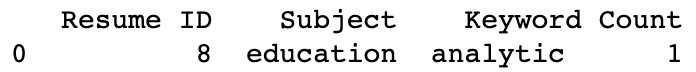

In [15]:
Image(filename='ID_8_education.png')

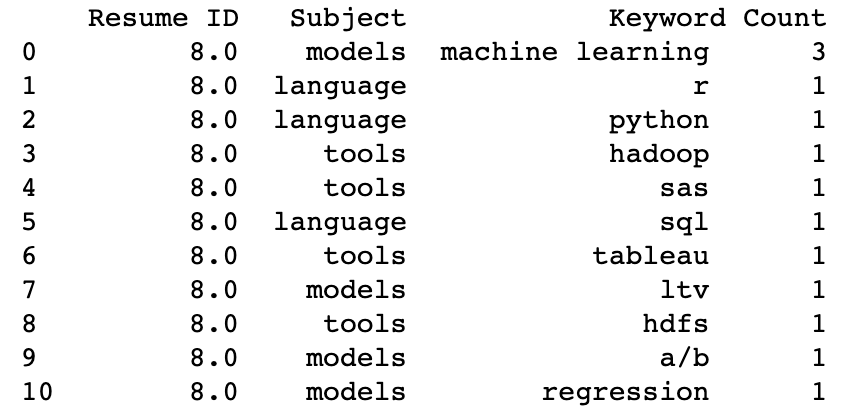

In [16]:
Image(filename='ID_8_skills.png')

In [17]:
# show the resume
index = next((index for (index, d) in enumerate(data) if d["id"] == 8), None)
data[index]

{'id': 8,
 'work experience': 6,
 'strength': '• 6+ years of working experience in Marketing & Pricing analytics • Strong analytical & quantitative skills; Extensive experience with statistical data analysis, machine learning, data visualization with massive dataset using R, Python, PySpark, Hadoop, SAS, SQL, Tableau • Good command of digital marketing strategy across channels in gaming and retail industry • Excellent project delivery, communication, and interpersonal skills, top performer (5%) on the team',
 'education': [{'Graduation date': '2013-09~2014-06',
   'University': 'UNIVERSITY OF ROCHESTER',
   'Education background': 'Master',
   'Major': 'Marketing Analytic'},
  {'Graduation date': '2010-09~2013-06',
   'University': 'RENMIN UNIVERSITY OF CHINA',
   'Education background': 'Bachelor',
   'Major': 'Double Major in Business Administration and Japanese (JLPT-N1)'}],
 'experience': [{'Time': '2019-05 ~ 至今',
   'Category': 'Full-time',
   'Company': 'APPLE',
   'Position': 'D

## Limitation and Reference

**Limitation**



- a: I built up the scoring model and assigned points based on my own understanding of the job description and data science, which may not perfectly match the criterion of the company. For example, maybe the company wants to emphasize more on the Hive skills in analytical tools and I assigned the weight of different tools equally.


- b: The model only reflects how many skills a candidate has while the model doesn't tell if the candidate has a good commend of the skill.


- c: When matching `"5-10 years of experience in data science"`, I am not able to rule out the candidate who has more than 5 years of working experience but less than 5 years of working experience in **data science**. The proportion is not high, but it is a logical problem of the model indeed. However, it is the best way I can figure out. If you have a more comprehensive way to match this, could you please send me an e-mail?


**Reference**


- [This article](https://towardsdatascience.com/do-the-keywords-in-your-resume-aptly-represent-what-type-of-data-scientist-you-are-59134105ba0d) helped me a lot to solve the problem.